### Install umap

In [2]:
#pip install umap-learn

### Install wget

In [3]:
#pip install wget

### Import modules

In [2]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import text_to_word_sequence

import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import umap #pip install umap-learn
import wget #pip install wget

### Download the pre-trained model from a GitHub repository

In [3]:
save_path = './Results/'
ModelSaveSameName = save_path+'ReutersM.hdf5'

if not os.path.exists(save_path):
    os.mkdir(save_path)
    
url = 'https://github.com/JunetaeKim/DeepLearningClass/raw/main/Week14/Results/ReutersM.hdf5'

if not os.path.exists(ModelSaveSameName):
    wget.download(url, ModelSaveSameName)


### Hyper-parameters

In [4]:
vocab_size = 50000
max_length = 100
embedding_dim = 10

### Data and Index load
#### Data are already be encoded as integers

In [5]:
### Load the data. The data returned will already be encoded as integers.
#### Words are ranked by how often they occur (in the training set) and only the num_words most frequent words are kept.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=vocab_size, test_split=0.2)

### Get the index mapping integers to words from the Reuters dataset.
word_index = reuters.get_word_index()

c:\users\user\anaconda3\envs\ai\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\users\user\anaconda3\envs\ai\lib\site-packages\tensorflow\python\keras\datasets\reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### Sequence length setting

In [6]:
X_train = sequence.pad_sequences(train_data, maxlen=max_length)
X_test = sequence.pad_sequences(test_data, maxlen=max_length)

### One-hot encoding for labels

In [7]:
Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

### Model architecture

In [8]:
InpL = Input(shape=(max_length, ))
EmbedL = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, name='Embedd')(InpL)
LSTML = LSTM(100)(EmbedL)
DenseL = Dense(50, activation='relu')(LSTML)
Outcome = Dense(len(np.unique(train_labels)), activation='softmax')(LSTML)

model = Model(InpL, Outcome)
model.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

### Pre-trained model load

In [9]:
model.load_weights(ModelSaveSameName)
model.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [10]:
model.evaluate(X_test, Y_test, batch_size=1000)

3/3 [==============================] - 2s 11ms/step - loss: 3.3537 - accuracy: 0.5616


[3.3465194702148438, 0.5596616268157959]

### Extracting Embeddings for Words Occurring More Than a Specified Cutoff Count

In [11]:
CutoffCount = 20
UsedWord_idx, UsedWordCount = np.unique(np.concatenate(train_data), return_counts=True)
UsedWord_idx = UsedWord_idx[UsedWordCount> CutoffCount]
train_labels

EmbeddedRes = model.get_layer('Embedd').weights[0].numpy()
UsedWords = EmbeddedRes[UsedWord_idx]
UsedWords.shape

(4567, 10)

### Performing UMAP to reduce the dimensionality of word vectors

In [12]:
# Reduce dimensionality using UMAP
Reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.2 )
UsedWords_2d = Reducer.fit_transform(UsedWords)

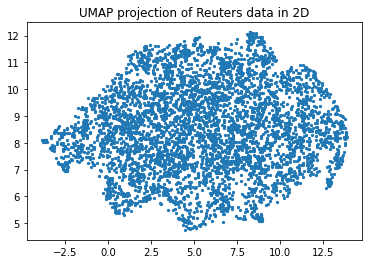

In [13]:
# Plot embeddings in 2D
plt.scatter(UsedWords_2d[:, 0], UsedWords_2d[:, 1], s=5)
plt.title('UMAP projection of Reuters data in 2D')
plt.show()